# SVG with page ordering of marked content

Here's a slightly more complicated SVG, as seen in https://github.com/dhdaines/playa/issues/196

In [1]:
import playa
import paves.image as pi
from urllib.request import urlopen
from pathlib import Path

In [2]:
path = Path("../samples/contrib/mutcd11thedition.pdf")
if not path.exists():
    with urlopen("https://mutcd.fhwa.dot.gov/pdfs/11th_Edition/mutcd11thedition.pdf") as f:
        path.write_bytes(f.read())

In [3]:
pdf = playa.open(path)

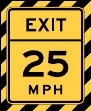

In [4]:
page = pdf.pages['48']
figs = list(page.structure.find_all('Figure'))
figure = figs[4]
pi.show(page).crop(figure.bbox)

In [5]:
x0, y0, x1, y1 = figure.bbox
width = round(x1 - x0)
height = round(y1 - y0)
left = round(x0)
top = round(y0)
bbox = " ".join(str(x) for x in (left, top, width, height))
svg = [f"<svg version='1.1' width='{page.width}' height='{page.height}' viewBox='{bbox}'>"]

from playa.content import TextObject, PathObject
objs = []
for c in figure.contents.page_order:
    for obj in c:
        if isinstance(obj, TextObject):
            x, y = obj.origin
            svg.append(f"<text x='{round(x)}' y='{round(y)}' font-size='{round(obj.size)}'>{obj.chars}</text>")
            objs.append(obj)
        elif isinstance(obj, PathObject):
            fcolor = scolor = "none"
            if obj.fill:
                fcolor = f"rgb({' '.join(str(round(x * 255)) for x in obj.gstate.ncolor.values)})"
            if obj.stroke:
                scolor = f"rgb({' '.join(str(round(x * 255)) for x in obj.gstate.scolor.values)})"
            program = []
            for seg in obj.segments:
                points = ", ".join(f"{round(x)} {round(y)}" for x, y in seg.points)
                if seg.operator in "mlc":
                    program.append(f"{seg.operator.upper()} {points}")
                elif seg.operator == "h":
                    program.append("Z")
                else:
                    print("unhandled segment", seg)
            svg.append(f"<path stroke='{scolor}' fill='{fcolor}' d='{' '.join(program)}'/>")
            objs.append(obj)
        else:
            print("unhandled object", obj)
svg.append("</svg>")

In [6]:
from IPython.display import SVG
SVG("\n".join(svg))